<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/UAS_Klasifikasi_ikan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library yang diperlukan
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import warnings

warnings.filterwarnings("ignore")
# Tambahan import untuk metrik
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import random
import numpy as np

# Set seed untuk reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Using device: cuda


# Load data & Preprocessing


In [ ]:
# Definisikan transformasi/preprocessing gambar
transform = transforms.Compose(
    [
        transforms.Resize(
            (224, 224)
        ),  # Resize gambar ke 224x224 untuk pretrained model
        transforms.ToTensor(),  # Konversi ke tensor
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        ),  # Normalisasi imagenet
    ]
)

In [ ]:
# Path ke dataset
data_dir = "dataset"

# Load dataset train, val, test
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "train"), transform=transform
)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, pin_memory=True)

num_classes = len(train_dataset.classes)
print("Kelas:", train_dataset.classes)

Kelas: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


# Model CNN RESNET50


In [ ]:
# Transfer learning dengan ResNet50
model = models.resnet50(pretrained=True)
# Ganti fully connected layer terakhir agar sesuai jumlah kelas
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Fine-tuning: freeze semua layer kecuali fc
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
# Setup loss function dan optimizer (hanya update fc)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)  # lebih kecil agar stabil

# Train


In [ ]:
# Inisialisasi list untuk menyimpan metric dan loss tiap epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

num_epochs = 20

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.fc.parameters(), max_norm=2.0)
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(
        all_labels, all_preds, average="macro", zero_division=0
    )
    train_rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)

    # --- VALIDASI ---
    model.eval()
    val_preds = []
    val_labels = []
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds, average="macro", zero_division=0)
    val_rec = recall_score(val_labels, val_preds, average="macro", zero_division=0)

    # Simpan metric dan loss ke list
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_precisions.append(train_prec)
    val_precisions.append(val_prec)
    train_recalls.append(train_rec)
    val_recalls.append(val_rec)

    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f},Train Prec: {train_prec:.4f},Train Rec: {train_rec:.4f} | "
        f"Val Acc: {val_acc:.4f},Val Prec: {val_prec:.4f},Val Rec: {val_rec:.4f}"
    )

Epoch 1/20, Train Loss: 2.6842 | Val Loss: 1.8582 | Train Acc: 0.2990,Train Prec: 0.4667,Train Rec: 0.1992 | Val Acc: 0.6074,Val Prec: 0.7026,Val Rec: 0.5174
Epoch 2/20, Train Loss: 1.5388 | Val Loss: 1.2142 | Train Acc: 0.6727,Train Prec: 0.7357,Train Rec: 0.6012 | Val Acc: 0.7430,Val Prec: 0.8051,Val Rec: 0.6931
Epoch 2/20, Train Loss: 1.5388 | Val Loss: 1.2142 | Train Acc: 0.6727,Train Prec: 0.7357,Train Rec: 0.6012 | Val Acc: 0.7430,Val Prec: 0.8051,Val Rec: 0.6931
Epoch 3/20, Train Loss: 1.0765 | Val Loss: 0.9474 | Train Acc: 0.7666,Train Prec: 0.7903,Train Rec: 0.7211 | Val Acc: 0.7935,Val Prec: 0.8143,Val Rec: 0.7633
Epoch 3/20, Train Loss: 1.0765 | Val Loss: 0.9474 | Train Acc: 0.7666,Train Prec: 0.7903,Train Rec: 0.7211 | Val Acc: 0.7935,Val Prec: 0.8143,Val Rec: 0.7633
Epoch 4/20, Train Loss: 0.8694 | Val Loss: 0.7942 | Train Acc: 0.8067,Train Prec: 0.8093,Train Rec: 0.7751 | Val Acc: 0.8237,Val Prec: 0.8278,Val Rec: 0.8024
Epoch 4/20, Train Loss: 0.8694 | Val Loss: 0.7942 | 

# Eval


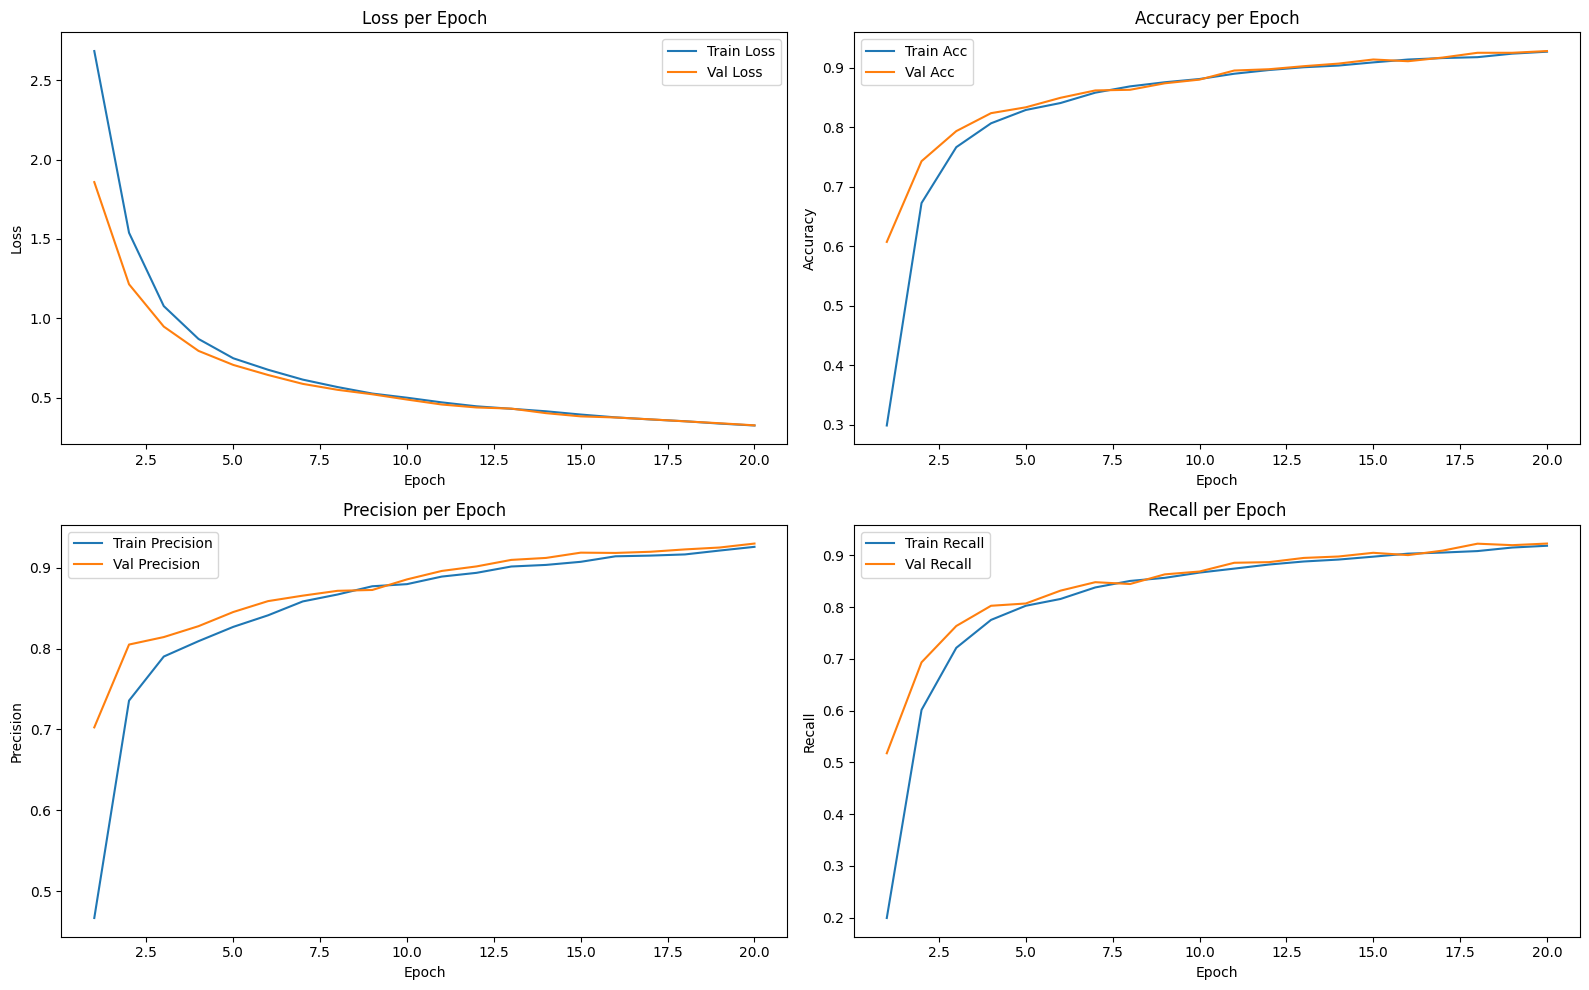

In [ ]:
# Plot loss dan metric tiap epoch
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Val Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision per Epoch")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Val Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import numpy as np

# Konversi ke numpy array jika belum
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Hitung metrik
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
print(f"Akurasi Test: {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro): {rec:.4f}")
print(f"F1-score (macro): {f1:.4f}")

Akurasi Test: 0.9270
Precision (macro): 0.9260
Recall (macro): 0.9183
F1-score (macro): 0.9218


In [ ]:
from sklearn.metrics import classification_report

# Menghitung classification report untuk hasil prediksi
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

                       precision    recall  f1-score   support

               Bangus       0.88      0.83      0.86       171
        Big Head Carp       0.90      0.91      0.90       201
   Black Spotted Barb       0.94      0.85      0.90       200
              Catfish       0.88      0.93      0.91       314
       Climbing Perch       0.85      0.84      0.84       152
 Fourfinger Threadfin       0.92      0.91      0.91       191
       Freshwater Eel       0.91      0.94      0.92       271
       Glass Perchlet       0.92      0.96      0.94       397
                 Goby       0.88      0.93      0.90       607
            Gold Fish       0.99      1.00      1.00       206
              Gourami       0.97      0.98      0.97       311
           Grass Carp       0.95      0.96      0.96      1222
 Green Spotted Puffer       0.99      0.99      0.99       110
          Indian Carp       0.98      0.93      0.95       262
  Indo-Pacific Tarpon       0.89      0.84      0.87  

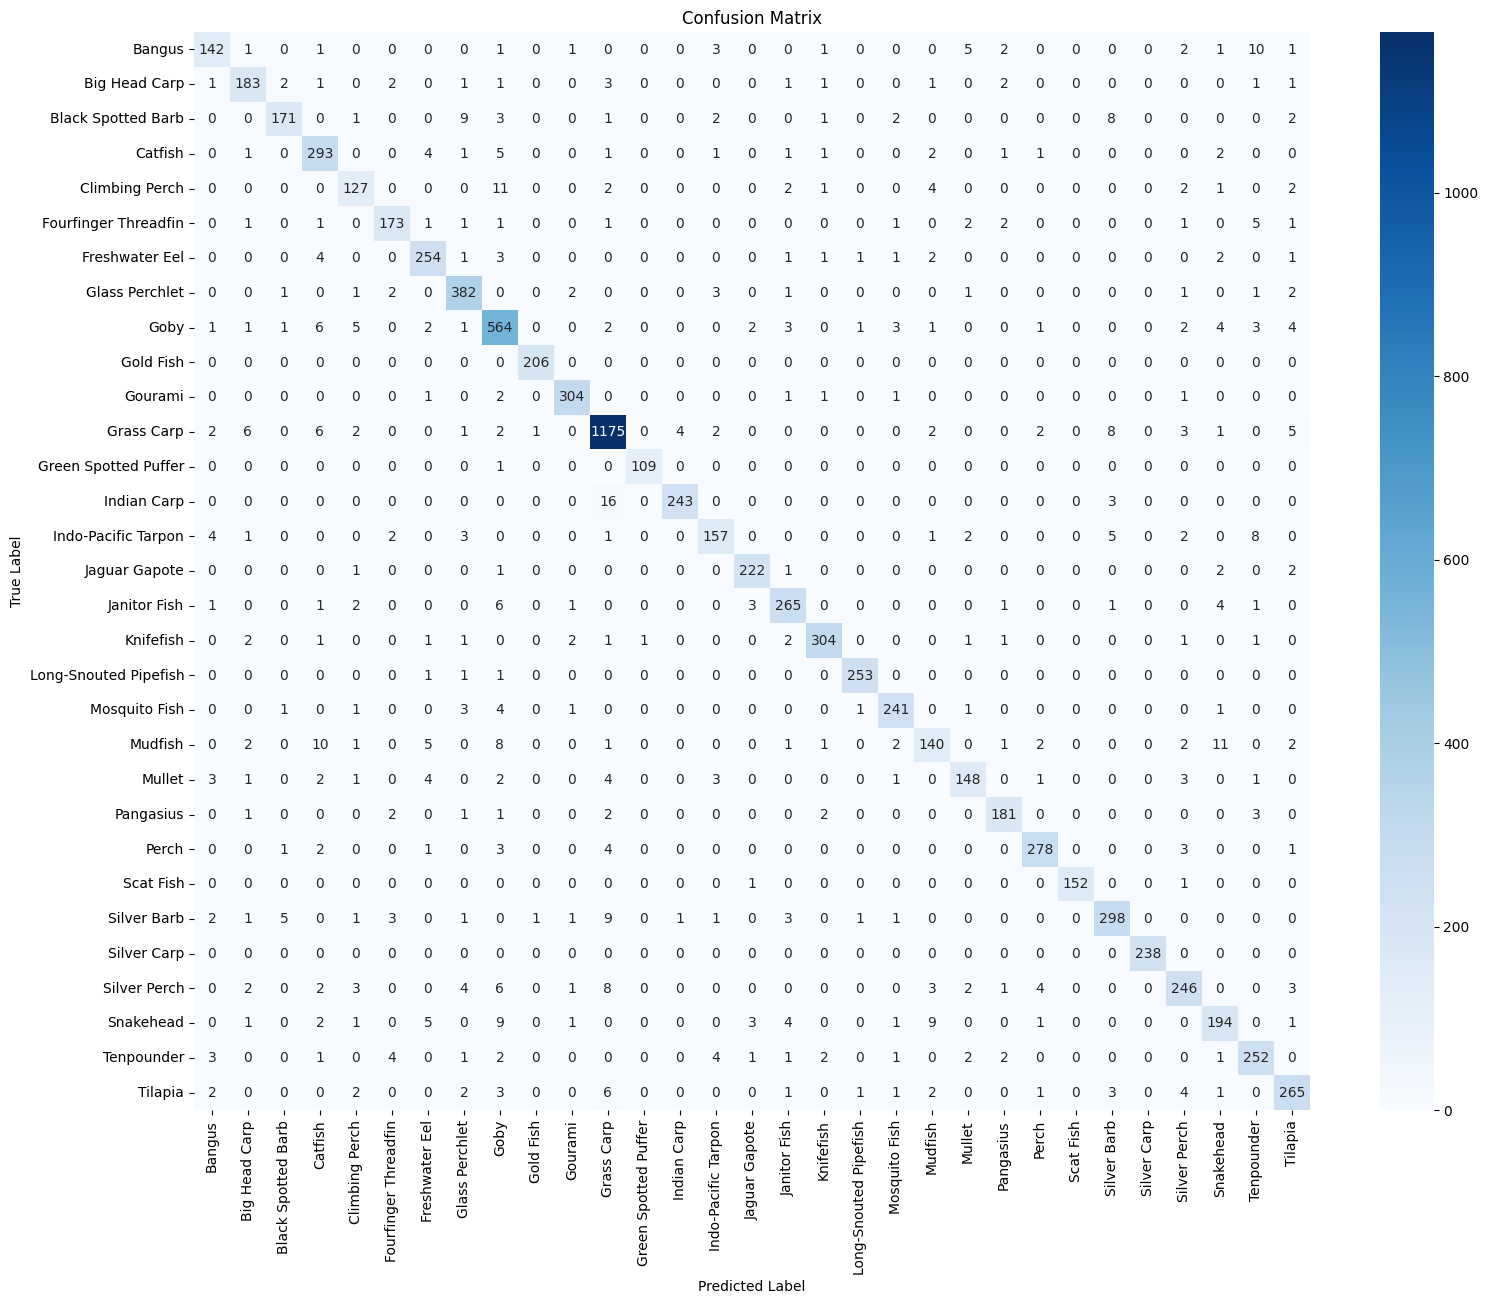

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(18, 14))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=train_dataset.classes,
    yticklabels=train_dataset.classes,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Usage


In [ ]:
from PIL import Image


def predict_image(image_path, model, transform, class_names, device):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)
        predicted_class = class_names[pred.item()]
    return predicted_class


image_path = r"dataset\train\Bangus\Bangus 1.jpg"
predicted_label = predict_image(
    image_path, model, transform, train_dataset.classes, device
)
print(f"Prediksi kelas: {predicted_label}")

Prediksi kelas: Bangus


# Kesimpulan


## Kesimpulan

### 1. Ringkasan Hasil

Eksperimen klasifikasi ikan menggunakan model transfer learning ResNet50 menunjukkan performa yang sangat baik, dengan akurasi keseluruhan sebesar **93%** pada data uji. Nilai precision, recall, dan f1-score rata-rata (macro) juga konsisten di atas 92%. Hal ini menandakan model mampu mengenali berbagai jenis ikan secara seimbang di antara kelas-kelas yang tersedia.

### 2. Analisis Performa Kelas

- **Kelas dengan performa tinggi:** Gold Fish, Silver Carp, dan Scat Fish memiliki precision dan recall mendekati atau sama dengan 1.00, menandakan ciri visual yang unik dan konsistensi data yang baik.
- **Kelas dengan performa lebih rendah:** Mudfish dan Climbing Perch memiliki nilai recall lebih rendah, kemungkinan akibat jumlah data yang terbatas, variasi intra-kelas tinggi, atau kemiripan visual dengan kelas lain.

### 3. Analisa dan Hipotesis

- **Keberhasilan model** didukung oleh kemampuan representasi fitur ResNet50 yang telah dilatih pada ImageNet, sehingga mampu mengenali pola visual umum dan spesifik pada ikan.
- **Transfer learning** memungkinkan adaptasi pengetahuan visual umum ke domain ikan melalui fine-tuning, sehingga model efektif membedakan spesies yang mirip sekalipun.
- **Distribusi data yang relatif seimbang** dan preprocessing yang tepat (normalisasi, augmentasi) turut mendukung generalisasi model.
- **Kelas minoritas atau dengan variasi visual tinggi** membutuhkan strategi khusus seperti augmentasi data atau penyesuaian bobot loss agar model tidak bias terhadap kelas mayoritas.

### 4. Potensi Pengembangan dan Aplikasi

- Model dapat diintegrasikan ke dalam aplikasi mobile untuk identifikasi ikan secara real-time, sistem monitoring stok ikan, atau alat bantu penelitian biodiversitas perairan.
- Pengembangan lebih lanjut dapat dilakukan dengan menambah data, eksplorasi teknik augmentasi, atau penggunaan arsitektur model yang lebih kompleks.
- Evaluasi pada data lapangan yang lebih bervariasi penting untuk memastikan robustitas model dalam kondisi nyata.

### 5. Kontribusi

Penelitian ini membuktikan bahwa deep learning dan transfer learning sangat relevan untuk klasifikasi citra biota air. Hasil ini dapat menjadi referensi dan pijakan untuk riset lanjutan di bidang klasifikasi spesies lain atau aplikasi serupa di bidang ekologi dan konservasi.
